In [1]:
import json
import time

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from kneed import KneeLocator
from scipy.sparse import csr_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

from tools import COLUMNS_CAT, COLUMNS_QUANT, datasets

pd.options.display.max_rows = 80

f3_scorer = metrics.make_scorer(metrics.fbeta_score, beta=3)
f5_scorer = metrics.make_scorer(metrics.fbeta_score, beta=5)

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1, random_state=1234)
df.shape

(1610494, 48)

## 1. Régression logistique

Pour la régression logistique, on enlève les premières colonnes pour les variables indicatrices.

In [3]:
datasets_df = datasets(df, drop='first')
X_quant_scaled = datasets_df['X_quant_scaled']
X_only_quant_scaled = datasets_df['X_only_quant_scaled']
y = datasets_df['y']

Columns_quant : default
Columns_cat : default
drop : first

Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


### 1.1. Méthode RFE

In [4]:
def run_RFE(model, n_features_to_select, X, y, export=None, sparse=False):
    # create the RFE model and select 3 attributes
    rfe = RFE(model, n_features_to_select=n_features_to_select)    
    if sparse:
        X_sparse = csr_matrix(X)
    else:
        X_sparse = X
    rfe = rfe.fit(X_sparse, y)

    # summarize the selection of the attributes
    #  print(rfe.support_)
    #  print(rfe.ranking_)
    
    dico = {"Rank": rfe.ranking_,
            "Support": rfe.support_}
    rf_df = pd.DataFrame(dico, index=X.columns).sort_values(by='Rank', ascending=True)

    display(rf_df)
    
    support = rf_df[rf_df.Support == True].index.to_list()
    
    columns_quant = sorted(list(set(support).intersection(set(COLUMNS_QUANT))))    
    columns_cat = sorted(list(set(support).difference(set(COLUMNS_QUANT))))
    
    print("Columns_quant :")
    display(columns_quant)
    print("\nColumns_cat :")
    display(columns_cat)    
    
    if export:        
        dico_export = {'columns_quant': columns_quant,
                       'columns_cat': columns_cat}
        with open(f"backups/{export}.json", 'w') as f:
            json.dump(dico_export, f, indent=2)
        print(f"\nExportation : backups/{export}.json")

In [5]:
%%time
model = LogisticRegression()
run_RFE(model, 8, X_quant_scaled, y)

,Rank,Support
campaignctrlast24h,1,True
ltf_nbpartnerdisplayssincelastclick,1,True
ltf_nbpartnerclick_90d,1,True
nbdayssincelastclick,1,True
nbdisplay_1hour,1,True
nbdisplayglobalapprox_1d_sum_xdevice,1,True
display_size,1,True
zonecostineuro,1,True
dayssincelastvisitdouble,2,False
contextid,3,False


Columns_quant :


['campaignctrlast24h',
 'display_size',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnerdisplayssincelastclick',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'zonecostineuro']


Columns_cat :


[]

CPU times: user 2min 49s, sys: 8min 6s, total: 10min 56s
Wall time: 15.5 s


In [6]:
%%time
model = LogisticRegression()
run_RFE(model, 3, X_quant_scaled, y)

,Rank,Support
campaignctrlast24h,1,True
display_size,1,True
zonecostineuro,1,True
nbdisplay_1hour,2,False
nbdayssincelastclick,3,False
nbdisplayglobalapprox_1d_sum_xdevice,4,False
ltf_nbpartnerdisplayssincelastclick,5,False
ltf_nbpartnerclick_90d,6,False
dayssincelastvisitdouble,7,False
contextid,8,False


Columns_quant :


['campaignctrlast24h', 'display_size', 'zonecostineuro']


Columns_cat :


[]

CPU times: user 3min 51s, sys: 12min 40s, total: 16min 31s
Wall time: 25.7 s


Pour ne pas avoir à définir un nombre de features, nous allons utiliser une méthode de Cross Validation qui permettra de calculer le nombre de features optimal.

### 1.2. Méthode RFECV

In [7]:
def run_RFECV(model, X, y, score=f3_scorer, min_features_to_select=1, n_jobs=-1, knee=False, sparse=False):
    rfecv = RFECV(estimator=model, step=1, cv=5,
                  scoring=score,
                  min_features_to_select=min_features_to_select,
                  n_jobs=n_jobs)
    if sparse:
        X_sparse = csr_matrix(X)
    else:
        X_sparse = X
    rfecv.fit(X_sparse, y)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Nombre de variables sélectionnées")
    if score == f3_scorer:
        plt.ylabel("Score F3 moyen")
    else:
        plt.ylabel(f"Score {str(score)} moyen")
    x = range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select)
    y = rfecv.grid_scores_
    plt.plot(x, y)
    if type(knee) == bool and knee:
        kneedle = KneeLocator(x, y)
        plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles="--", color='black', label="Coude")
    if type(knee) == int:
        plt.vlines(knee, plt.ylim()[0], plt.ylim()[1], linestyles="--", color='black', label="Coude")
    plt.show()

    if type(knee) == bool and knee:
        print(f"Nombre optimal de variables à sélectionner (coude) : {kneedle.knee}")
        return kneedle.knee
    if type(knee) == int:
        print(f"Nombre optimal de variables à sélectionner (coude) : {knee}")
        return knee

#### 1.2.1. Variables quantitatives

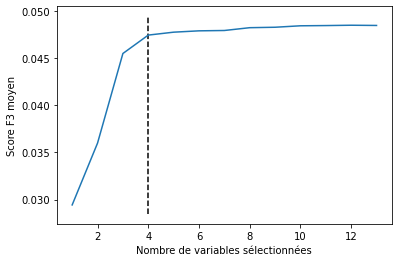

Nombre optimal de variables à sélectionner (coude) : 4
CPU times: user 1min 18s, sys: 4min 3s, total: 5min 22s
Wall time: 35 s


In [8]:
%%time
model = LogisticRegression()
knee = run_RFECV(model, X_quant_scaled, y, score=f3_scorer, knee=True)

Le nombre de features optimal semble être 4. Nous allons donc maintenant calculer une RFE avec cette valeur pour déterminer les features à conserver.

In [9]:
%%time
model = LogisticRegression()
run_RFE(model, 4, X_quant_scaled, y)

,Rank,Support
campaignctrlast24h,1,True
nbdisplay_1hour,1,True
display_size,1,True
zonecostineuro,1,True
nbdayssincelastclick,2,False
nbdisplayglobalapprox_1d_sum_xdevice,3,False
ltf_nbpartnerdisplayssincelastclick,4,False
ltf_nbpartnerclick_90d,5,False
dayssincelastvisitdouble,6,False
contextid,7,False


Columns_quant :


['campaignctrlast24h', 'display_size', 'nbdisplay_1hour', 'zonecostineuro']


Columns_cat :


[]

CPU times: user 4min 1s, sys: 12min 32s, total: 16min 34s
Wall time: 23.7 s


#### 1.2.2. Variables quantitatives + catégorielles

Rajoutons à présent les variables catégorielles.

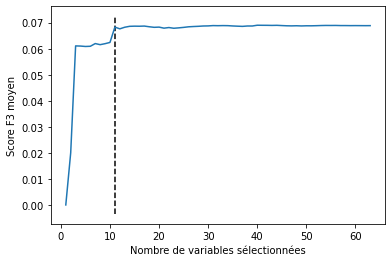

Nombre optimal de variables à sélectionner (coude) : 11
CPU times: user 3min 48s, sys: 8.93 s, total: 3min 57s
Wall time: 9min 42s


In [10]:
%%time
model = LogisticRegression()
knee = run_RFECV(model, X_only_quant_scaled, y, score=f3_scorer, knee=11, sparse=True)

Le nombre de features optimal semble être 11. Nous allons donc maintenant calculer une RFE avec cette valeur pour déterminer les features à conserver.

In [11]:
%%time
model = LogisticRegression()
run_RFE(model, 11, X_only_quant_scaled, y, export='RFECV_LR', sparse=True)

,Rank,Support
zonecostineuro,1,True
device_type_Desktop,1,True
display_env_app_ios,1,True
display_size,1,True
nbdisplay_1hour,1,True
is_interstitial_True,1,True
nbdayssincelastclick,1,True
campaignscenario_13,1,True
device_type_iPhone,1,True
campaignctrlast24h,1,True


Columns_quant :


['campaignctrlast24h',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro']


Columns_cat :


['campaignscenario_13',
 'device_type_Desktop',
 'device_type_iPhone',
 'display_env_app_ios',
 'is_interstitial_True',
 'target_env_2']


Exportation : backups/RFECV_LR.json
CPU times: user 5min 47s, sys: 6.99 s, total: 5min 54s
Wall time: 5min 54s


## 2. Random Forest

Pour les modèles de type arbre, il n'est pas nécessaire d'enlever toutes les premières colonnes des variables indicatrices.

In [12]:
datasets_df = datasets(df, drop='if_binary', verbose=False)
X = datasets_df['X']
y = datasets_df['y']

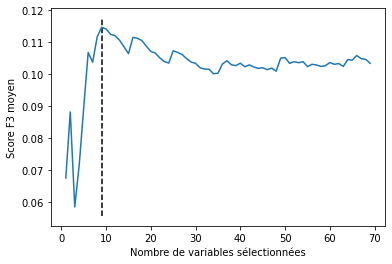

Nombre optimal de variables à sélectionner (coude) : 9
CPU times: user 9h 48min 15s, sys: 1min 44s, total: 9h 49min 59s
Wall time: 2h 50min 34s


In [13]:
%%time
model = RandomForestClassifier(n_jobs=10)
knee = run_RFECV(model, X, y, score=f3_scorer, n_jobs=5, knee=9)

Le nombre de features optimal semble être 9. Nous allons donc maintenant calculer une RFE avec cette valeur pour déterminer les features à conserver.

In [14]:
%%time
model = RandomForestClassifier(n_jobs=28)
run_RFE(model, 9, X, y, export='RFECV_Forest')

,Rank,Support
contextid,1,True
campaignctrlast24h,1,True
dayssincelastvisitdouble,1,True
is_interstitial_True,1,True
zonecostineuro,1,True
nbdayssincelastclick,1,True
nbdisplay_1hour,1,True
nbdisplayglobalapprox_1d_sum_xdevice,1,True
display_size,1,True
weekday_Monday,2,False


Columns_quant :


['campaignctrlast24h',
 'contextid',
 'dayssincelastvisitdouble',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'zonecostineuro']


Columns_cat :


['is_interstitial_True']


Exportation : backups/RFECV_Forest.json
CPU times: user 16h 31min 50s, sys: 3min 28s, total: 16h 35min 19s
Wall time: 40min 8s


## 3. XGBoost

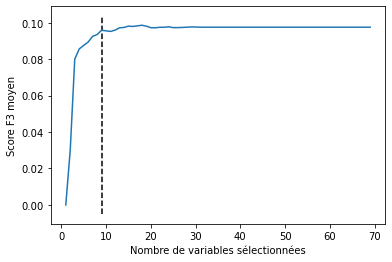

Nombre optimal de variables à sélectionner (coude) : 9
CPU times: user 3h 52min 19s, sys: 50.6 s, total: 3h 53min 9s
Wall time: 1h 11min 16s


In [15]:
%%time
model = XGBClassifier(n_jobs=10)
knee = run_RFECV(model, X, y, score=f3_scorer, n_jobs=5, knee=True)

In [16]:
%%time
model = XGBClassifier(n_jobs=28)
run_RFE(model, 9, X, y, export='RFECV_XGBoost')

,Rank,Support
contextid,1,True
campaignctrlast24h,1,True
is_interstitial_True,1,True
zonecostineuro,1,True
device_type_iPad,1,True
nbdisplay_1hour,1,True
device_type_Desktop,1,True
device_type_Android,1,True
nbdayssincelastclick,1,True
campaignvertical_23.0,2,False


Columns_quant :


['campaignctrlast24h',
 'contextid',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro']


Columns_cat :


['device_type_Android',
 'device_type_Desktop',
 'device_type_iPad',
 'is_interstitial_True']


Exportation : backups/RFECV_XGBoost.json
CPU times: user 6h 47min 55s, sys: 57.3 s, total: 6h 48min 52s
Wall time: 21min 50s


In [17]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 05:21:45
